# Measuring the spin exchange rate

In [1]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.daq.nidaqmx_tools as ndaq
import one_ring.daq.stanford_research_systems as srs
import importlib
import one_ring.base.signal_tools as sit
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
from scipy import constants
%matplotlib widget
import time as tm
import pyvisa as visa
import one_ring.daq.visa_instruments as nvisa
plt.style.use("dark_background")
import pandas as pd
import one_ring.daq.thorlabs as thor
import one_ring.daq.tektronix as tek
import one_ring.base.pandas_tools as pdt

# Magnetic Field

In [123]:
B_ambient = np.array([22.5, 10.5, 7.0]) * ureg.uT
B_3axis = np.array([0.2, 0.2 , 0.2]) * ureg.uT /ureg.mA
R_3axis = np.array([11.2, 9.5, 8.1]) * ureg.ohm
B_target = ([0, 50, 0]) * ureg. uT
B_kick = ([0, 0, 0]) * ureg.uT

In [124]:
#Volts to cancel ambient field
V_cancel = ((B_ambient / B_3axis) * R_3axis).to(ureg.V)
V_final = ((B_target / B_3axis) * R_3axis).to(ureg.V)
V_kick = ((B_kick/B_3axis) * R_3axis).to(ureg.V)

For modulating the Bx field to cause a 1uT kick i need to modulate the Bx field across these currents
112.42 * ureg.mA --> 117.38 * ureg.mA

In [125]:
V_cancel + V_final

Magnitude,[1.26 2.8737500000000002 0.28350000000000003]
Units,volt


In [126]:
V_kick + V_cancel + V_final

Magnitude,[1.26 2.8737500000000002 0.28350000000000003]
Units,volt


# Spectrum Analyzer

In [ ]:
bw = 482*ureg.kHz
f_res = 1*ureg.Hz
SA = ndaq.SpectrumAnalyzer(bw, f_res)

In [ ]:
SA.configure_channels()

In [ ]:
SA.display()

# PDB Viewer

In [ ]:
PDB_Monitor.close()

In [ ]:
fs = 1 * ureg.kHz #f3dB is 159kHz
dt = 1/fs
PDB_Monitor = ndaq.DAQViewer(dt)

In [ ]:
PDB_Monitor.configure_channels()

In [ ]:
PDB_Monitor.display()

# Finite Generation Measurement

In [114]:
def larmor(B):
    return (scipy.constants.physical_constants['electron gyromagn. ratio over 2 pi'][0] * ureg.MHz / ureg.T/ 4 * B).to(ureg.kHz)


In [177]:
larmor(50*ureg.uT)

<Quantity(350.311915, 'kilohertz')>

In [7]:
fs = 1 * ureg.MHz
acq_time = 1*ureg.s
ao_sample_rate = fs
FGM = ndaq.FiniteGenerationAndMeasurement(fs,acq_time, ao_sample_rate)

In [8]:
FGM.configure_channels()

In [9]:
fs_out = FGM.configure_timings()

In [159]:
samples_per_call = int(round(1*ureg.s*fs_out))
yi = 0
yf = -1
transition_time = 10e-10
hold_time = 3*ureg.ms
t_start = 0.1 *ureg.s
t2_expected = 100*ureg.us
field = 50*ureg.uT
field_freq = larmor(field)
field_period = (1/field_freq).to(ureg.s)
signal = sit.TanhWindow(fs_out, 2000, yi, yf, transition_time, hold_time,t_start=t_start.m)

In [160]:
interval = 1
signal_x, signal_y = signal.generate_for(interval)

In [161]:
FGM.configure_tasks(signal_y)

In [162]:
FGM.start()

In [163]:
read_data = FGM.read(blocking=True)

In [164]:
FGM.stop()

In [165]:
data = read_data[0,:]
t_array = FGM.ai_task.generate_time(read_data.size)

C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


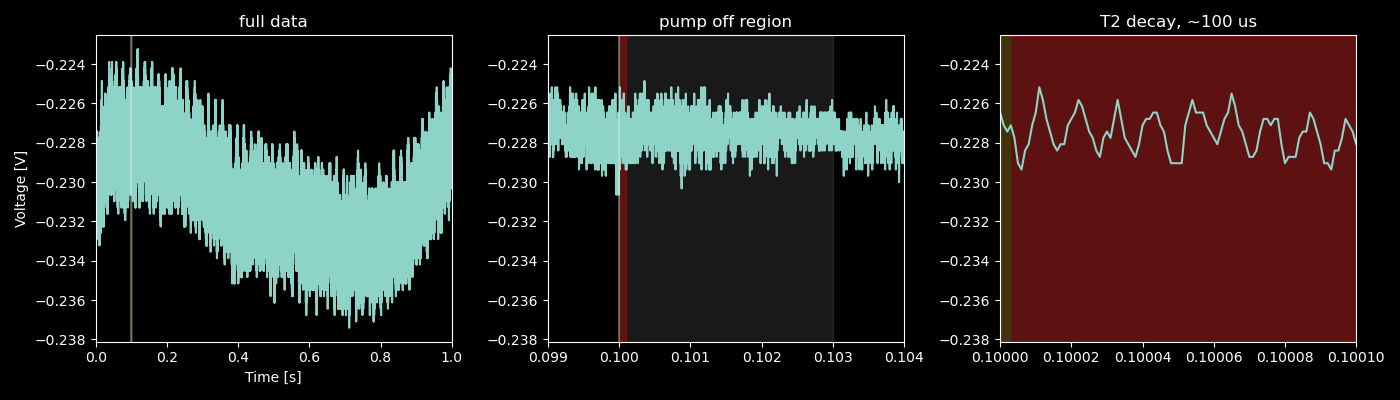

In [166]:
fig, axes = plt.subplots(figsize=(14,4),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]
#ax.plot(signal_x, signal_y,label='Analogue Out')
ax.plot(t_array, data,label='Measured Voltage')
ax1.plot(t_array, data,label='Measured Voltage')
ax2.plot(t_array, data,label='Measured Voltage')
#ax.plot(signal_x, signal_y,label='Analogue Out')
#ax.plot(signal_x, data,label='Measured Voltage')

ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
for axis in [ax, ax1,ax2]:
    axis.axvline(t_start.m,alpha=0.3)
    axis.axvspan(t_start.m, (t_start+hold_time.to(ureg.s)).m ,alpha=0.1,color='white')
    axis.axvspan(t_start.m, (t_start + t2_expected).to(ureg.s).m,alpha=0.3, color='red')
    axis.axvspan(t_start.m, (t_start + field_period).to(ureg.s).m,alpha=0.3, color='green')

ax.set_title('full data')
ax1.set_title('pump off region')
ax2.set_title('T2 decay, ~100 us')

ax.set_xlim(0.0,1)
ax1.set_xlim(0.099, 0.104)
ax2.set_xlim(t_start.to(ureg.s).m, (t_start + t2_expected).to(ureg.s).m)

plt.tight_layout()
plt.show()

In [171]:
df = pd.DataFrame(data,t_array.m, columns=['Voltage'])
end_series = (0.1*ureg.s + (200*ureg.us)).to(ureg.s).m
fid_df = df[(df.index>=0.099999) & (df.index < end_series)]

In [172]:
fitter = fitt.T2DecayFitter()

In [175]:
fit =fitter.fit(fid_df.index.to_numpy(), fid_df['Voltage'].to_numpy(),guess=(0.08,350000,0,0,1,41000))

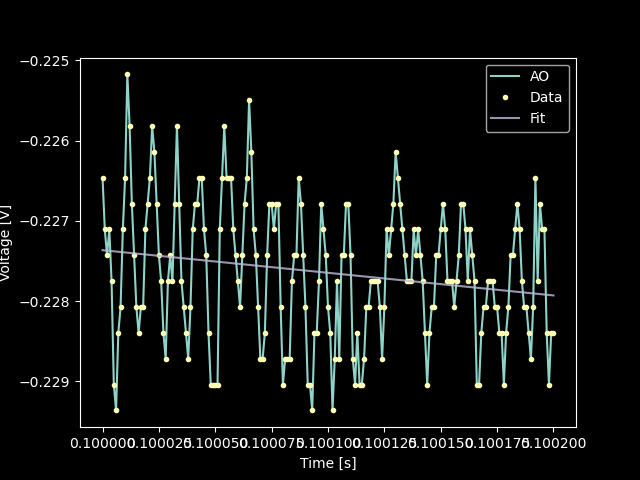

In [176]:
fig, ax = plt.subplots()
ax.plot(fid_df.index, fid_df,label='AO')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.legend()
fit.plot_fit(fkwargs={'alpha':0.8})
plt.show()

In [ ]:
(1/((0.1000526 - 0.10002821) * ureg.s)).to(ureg.Hz)

In [ ]:
fit.fit_parameters

In [ ]:
(1/larmor(10*ureg.uT)).to(ureg.s)

In [ ]:
((154.60-149.55) * ureg.mA) / (0.1 * ureg.V)

In [ ]:
5 * ureg.uT / (0.2*ureg.uT/ureg.mA)